This classifier is part of this tutorial by Mikael Konutgan that can be found [here](https://www.raywenderlich.com/5554-machine-learning-end-to-end-classification)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline

In [3]:
RANDOM_STATE = 200

In [4]:
def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

def plot_confusion_matrix(cm, class_names):
    import itertools
   
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=color)
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
    plt.show()

In [5]:
credit = pd.read_csv('https://koenig-media.raywenderlich.com/uploads/2018/07/Credit.csv', index_col=0)
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Eye Color,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Hazel,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Blue,903
3,104.593,7075,514,4,71,11,Male,No,No,Blue,580
4,148.924,9504,681,3,36,11,Female,No,No,Blue,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Hazel,331


## Your code goes below here

In [6]:
# We make a copy of the credit dataset to be able to cleanly transform the dataset. credit_ will hold the ready-to-use data after processing is complete.
credit_ = credit.copy()
# print(credit_)

# For Student and Married, we label encode Yes to 1 and No to 0.
credit_["Student"] = credit["Student"].map(lambda student: 1 if student == "Yes" else 0)

credit_["Married"] = credit["Married"].map(lambda married: 1 if married == "Yes" else 0)

# Here, you also do the same for the Gender field, while renaming the column to Female. 
credit_["Female"] = credit["Gender"].map(lambda gender: 1 if gender == "Female" else 0)
credit_.drop("Gender", axis=1, inplace=True)

#  We display the top rows from the data to verify your processing steps were successful.
credit_.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Eye Color,Balance,Female
1,14.891,3606,283,2,34,11,0,1,Hazel,333,0
2,106.025,6645,483,3,82,15,1,1,Blue,903,1
3,104.593,7075,514,4,71,11,0,0,Blue,580,0
4,148.924,9504,681,3,36,11,0,0,Blue,964,1
5,55.882,4897,357,2,68,16,0,1,Hazel,331,0


Most machine learning algorithms will misinterpret this information though. An algorithm like logistic regression would learn that Eye Color with value 2, will have a stronger effect than 1. A much better approach is using one-hot encoding.

### One-Hot Encoding

When using one-hot encoding, also called Dummy Variables, we create as many columns as there are distinct values. Each column then becomes 0 or 1, depending on if the original value for that row was equal to the new column or not. For example, if the row’s value is Blue, then in the one-hot encoded data, the Blue column would be 1, then both the Green, and Hazel columns would be 0.

In [7]:
pd.get_dummies(credit_["Eye Color"])

,Blue,Green,Hazel
1,0,0,1
2,1,0,0
3,1,0,0
4,1,0,0
5,0,0,1
6,0,0,1
7,0,1,0
8,1,0,0
9,0,0,1
10,0,1,0


In [8]:
# We make a copy of the credit dataset to be able to cleanly transform the dataset. credit_ will hold the ready-to-use data after processing is complete.
credit_ = credit.copy()
# print(credit_)

# For Student and Married, we label encode Yes to 1 and No to 0.
credit_["Student"] = credit["Student"].map(lambda student: 1 if student == "Yes" else 0)

credit_["Married"] = credit["Married"].map(lambda married: 1 if married == "Yes" else 0)

# Here, you also do the same for the Gender field, while renaming the column to Female. 
credit_["Female"] = credit["Gender"].map(lambda gender: 1 if gender == "Female" else 0)
credit_.drop("Gender", axis=1, inplace=True)

# We drop first value to save space because the last value can be inferred from the other two.
eye_color = pd.get_dummies(credit["Eye Color"], drop_first=True)

# Then, we use concat to concatenate the dummy columns to the data frame at the end.
credit_ = pd.concat([credit_.drop("Eye Color", axis=1), eye_color], axis=1)

#  We display the top rows from the data to verify your processing steps were successful.
credit_.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Female,Green,Hazel
1,14.891,3606,283,2,34,11,0,1,333,0,0,1
2,106.025,6645,483,3,82,15,1,1,903,1,0,0
3,104.593,7075,514,4,71,11,0,0,580,0,0,0
4,148.924,9504,681,3,36,11,0,0,964,1,0,0
5,55.882,4897,357,2,68,16,0,1,331,0,0,1


## Target Label

In [9]:
# We make a copy of the credit dataset to be able to cleanly transform the dataset. credit_ will hold the ready-to-use data after processing is complete.
credit_ = credit.copy()
# print(credit_)

# For Student and Married, we label encode Yes to 1 and No to 0.
credit_["Student"] = credit["Student"].map(lambda student: 1 if student == "Yes" else 0)

credit_["Married"] = credit["Married"].map(lambda married: 1 if married == "Yes" else 0)

# Here, you also do the same for the Gender field, while renaming the column to Female. 
credit_["Female"] = credit["Gender"].map(lambda gender: 1 if gender == "Female" else 0)
credit_.drop("Gender", axis=1, inplace=True)

# We drop first value to save space because the last value can be inferred from the other two.
eye_color = pd.get_dummies(credit["Eye Color"], drop_first=True)

# Then, we use concat to concatenate the dummy columns to the data frame at the end.
credit_ = pd.concat([credit_.drop("Eye Color", axis=1), eye_color], axis=1)

# For a Rating greater than 600, the label will be 1 (creditworthy). Otherwise, we set it to 0.
credit_["Creditworthy"] = credit["Rating"].map(lambda val: 0 if val < 600 else 1)
credit_.drop("Rating", axis=1, inplace=True)

#  We display the top rows from the data to verify your processing steps were successful.
credit_.head()

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Female,Green,Hazel,Creditworthy
1,14.891,3606,2,34,11,0,1,333,0,0,1,0
2,106.025,6645,3,82,15,1,1,903,1,0,0,0
3,104.593,7075,4,71,11,0,0,580,0,0,0,0
4,148.924,9504,3,36,11,0,0,964,1,0,0,1
5,55.882,4897,2,68,16,0,1,331,0,0,1,0


## Training and Cross Validation

In [10]:
# X = credit_[["Age", "Education", "Student", "Married"]]
X = credit_[["Income", "Education", "Student", "Married"]]

y = credit_["Creditworthy"]

# You're selecting four of the features on which to train the model. 
# We are storing them in X. The Creditworthy column is your target, named y.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

In [11]:
# We use logistic regression as the classifier.
estimator = LogisticRegression(random_state=RANDOM_STATE)
# We train — or "fit" — the classifier
estimator.fit(X_train, y_train)
# y_true will hold the true value of the y column that is the creditworthiness value.
y_true = y_test
# y_pred holds the predicted new values of the creditworthiness.
y_pred = estimator.predict(X_test)
# Logistic regression is a classification algorithm that actually predicts a probability.
y_score = estimator.predict_proba(X_test)[:, 0]

In [12]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.96499999999999997

In [13]:
confusion_matrix(y_true=y_true, y_pred=y_pred)

array([[184,   5],
       [  2,   9]])

In [14]:
precision_score(y_true=y_true, y_pred=y_pred)

0.6428571428571429

In [15]:
recall_score(y_true=y_true, y_pred=y_pred)

0.81818181818181823

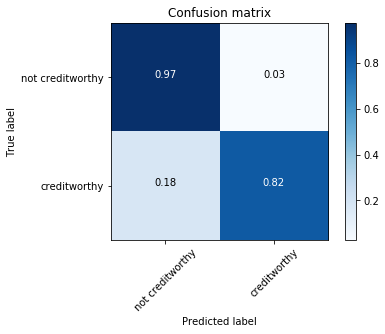

In [16]:
plot_confusion_matrix(cm=confusion_matrix(y_true=y_true, y_pred=y_pred),
                      class_names=["not creditworthy", "creditworthy"])

In [17]:
# We use logistic regression as the classifier.
estimator = LogisticRegression(random_state=RANDOM_STATE)
# We train — or "fit" — the classifier
estimator = LogisticRegression(random_state=RANDOM_STATE)
estimator.fit(X_train, y_train)
estimator.fit(X_train, y_train)
# y_true will hold the true value of the y column that is the creditworthiness value.
y_true = y_test
# y_pred holds the predicted new values of the creditworthiness.
y_pred = estimator.predict(X_test)
# Logistic regression is a classification algorithm that actually predicts a probability.
y_score = estimator.predict_proba(X_test)[:, 0]



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=200, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)